# SPNC thermals
Code for experimenting with the effects of thermal variation on ML performance

Set up imports:

In [11]:
"""
Import handeling and Dependancy info

Local Dependancies
------------------
machine_learning_library  : v0.1.2
    This repository will need to be on your path in order to work.
    This is achieved with repo_tools module and a path find function
    Add to the searchpath and repos tuples if required


"""

import numpy as np
import matplotlib.pyplot as plt

# Sort out relative paths
import sys
from pathlib import Path
repodir = Path('..').resolve()
try:
    sys.path.index(str(repodir))
except ValueError:
    sys.path.append(str(repodir))

#tuple of Path variables
searchpaths = (Path.home() / 'repos', )
#tuple of repos
repos = ('machine_learning_library',)

# local imports
from SPNC import spnc
#ML specific
from SPNC.deterministic_mask import fixed_seed_mask, max_sequences_mask
import SPNC.repo_tools
SPNC.repo_tools.repos_path_finder(searchpaths, repos) #find ml library
from single_node_res import single_node_reservoir
import ridge_regression as RR
from linear_layer import *
from mask import binary_mask
from utility import *
from NARMA10 import NARMA10
from sklearn.metrics import classification_report

Establish shared parameters

In [12]:
'''
NARMA10 response
'''

# NARMA parameters
Ntrain = 100
Ntest = 50

# Net Parameters
Nvirt = 5
m0 = 0.003
bias = True

# Misc parameters
seed_NARMA = None
fixed_mask = False
spacer = 5

# Resevoir parameters
h = 0.4
theta_H = 90
k_s_0 = 0
phi = 45
beta_prime = 20

theta = 0.4
gamma = 0.132
delay_feedback = 0
params = {'theta': theta, 'gamma' : gamma,'delay_feedback' : delay_feedback,'Nvirt' : Nvirt}
spnres = spnc.spnc_anisotropy(h,theta_H,k_s_0,phi,beta_prime)
transform = spnres.gen_signal_fast_delayed_feedback

spnreshigher = spnc.spnc_anisotropy(h,theta_H,k_s_0,phi,beta_prime)
transformhigher = spnreshigher.gen_signal_fast_delayed_feedback

Data and net setup

In [13]:
# Lets get into it
print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)

x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

seed NARMA: None
Samples for training:  100
Samples for test:  50
Nin = 1 , Nout =  100 , Nvirt =  5


Training and testing:

Using Nthreads =  1
Seed Training: 1234
l= 4.5399929762484854e-05 0.0072723690906735
l= 5.017468205617528e-05 0.0073052390737778595
l= 5.5451599432176945e-05 0.007337255024371892
l= 6.128349505322202e-05 0.007368408496224424
l= 6.772873649085378e-05 0.007398717813404275
l= 7.485182988770046e-05 0.007428224826364497
l= 8.272406555663209e-05 0.007456991592183461
l= 9.142423147817311e-05 0.007485097238902542
l= 0.00010103940183709307 0.007512635242237872
l= 0.00011166580849011438 0.00753971129785494
l= 0.0001234098040866791 0.007566441915539115
l= 0.0001363889264820109 0.0075929537958684705
l= 0.00015073307509547596 0.007619383978708707
l= 0.00016658581098763264 0.007645880680334459
l= 0.00018410579366757822 0.007672604666699462
l= 0.00020346836901064308 0.007699730948876875
l= 0.000224867324178847 0.0077274505370205455
l= 0.00024851682710795055 0.007755971954796037
l= 0.0002746535699721406 0.0077855221995941516
l= 0.0003035391380788646 0.007816346836916056
l= 0.00033546262790250947 0.007

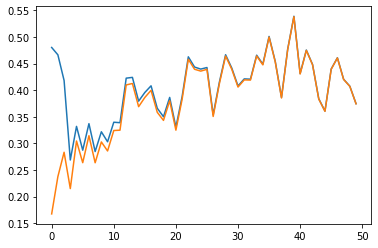

Error and NRMSE for normal testing 0.003541884827570799 0.669194780889218
Error and NRMSE for higher temp testing 0.0031877863355543675 0.6348628728783052


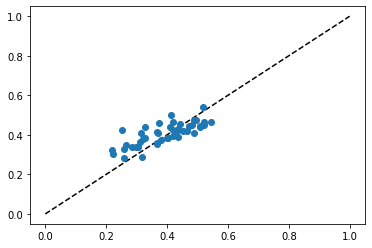

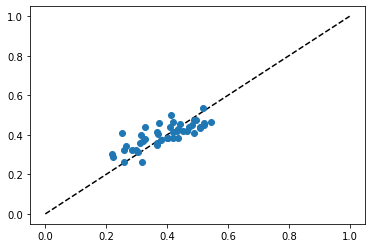

In [14]:
# Training
S_train, J_train = snr.transform(x_train,params)
np.size(S_train)
seed_training = 1234
RR.Kfold_train(net,S_train,y_train,10, quiet = False)

# Testing
S_test, J_test = snr.transform(x_test,params)
#test with the other transform...
snr.res = transformhigher
S_test_higher, J_test_higher = snr.transform(x_test,params)


print("Spacer NRMSE:"+str(spacer))
pred = net.forward(S_test)
pred_higher = net.forward(S_test_higher)
plt.plot(pred)
plt.plot(pred_higher)
plt.show()
np.size(pred)
error = MSE(pred[spacer:], y_test[spacer:])
predNRMSE = NRMSE(pred[spacer:], y_test[spacer:])
print('Error and NRMSE for normal testing', error, predNRMSE)

error_higher = MSE(pred_higher[spacer:], y_test[spacer:])
predNRMSE_higher = NRMSE(pred_higher[spacer:], y_test[spacer:])
print('Error and NRMSE for higher temp testing', error_higher, predNRMSE_higher)

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred[spacer:],'o')
plt.show()

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred_higher[spacer:],'o')
plt.show()